In [95]:
from mplsoccer.pitch import Pitch
from mplsoccer.statsbomb import read_event, EVENT_SLUG
import os
import pandas as pd
import numpy as np
from pandas import json_normalize
import requests

In [106]:
#Load in all match events 
events = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/8658.json')
events = events.json()

#Transform JSON into a dataframe 
df = json_normalize(events, sep = "_")

In [107]:
df.head(5)

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_type_id,pass_type_name,pass_body_part_id,pass_body_part_name,carry_end_location,under_pressure,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,duel_type_id,duel_type_name,pass_aerial_won,duel_outcome_id,duel_outcome_name,counterpress,interception_outcome_id,interception_outcome_name,pass_switch,pass_cross,dribble_outcome_id,dribble_outcome_name,foul_committed_type_id,foul_committed_type_name,foul_won_defensive,clearance_aerial_won,ball_recovery_recovery_failure,foul_committed_advantage,foul_won_advantage,injury_stoppage_in_chain,pass_backheel,pass_assisted_shot_id,pass_shot_assist,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_technique_id,shot_technique_name,shot_type_id,shot_type_name,shot_outcome_id,shot_outcome_name,shot_body_part_id,shot_body_part_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,goalkeeper_outcome_id,goalkeeper_outcome_name,foul_committed_card_id,foul_committed_card_name,pass_goal_assist,shot_deflected,block_deflection,foul_committed_penalty,pass_cut_back,shot_aerial_won,shot_first_time,goalkeeper_technique_id,goalkeeper_technique_name,goalkeeper_body_part_id,goalkeeper_body_part_name,pass_deflected,dribble_overrun,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name
0,47638847-fd43-4656-b49c-cff64e5cfc0a,1,1,00:00:00.000,0,0,1,0.000,35,Starting XI,771,France,1,Regular Play,771,France,442.0,"[{'player': {'id': 3099, 'name': 'Hugo Lloris'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0c04305d-5615-4520-9be5-7c232829954b,2,1,00:00:00.000,0,0,1,1.412,35,Starting XI,771,France,1,Regular Play,785,Croatia,433.0,"[{'player': {'id': 3444, 'name': 'Danijel Suba...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c5e17439-efe2-480b-9cff-1600998674d7,3,1,00:00:00.000,0,0,1,0.000,18,Half Start,771,France,1,Regular Play,771,France,NaN,NaN,[7e1460eb-c572-4059-8cd4-cec4857f818d],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7e1460eb-c572-4059-8cd4-cec4857f818d,4,1,00:00:00.000,0,0,1,0.000,18,Half Start,771,France,1,Regular Play,785,Croatia,NaN,NaN,[c5e17439-efe2-480b-9cff-1600998674d7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,918ffaaf-3cee-41e5-87e2-4bcc8d43a859,5,1,00:00:00.400,0,0,2,1.159,30,Pass,785,Croatia,9,From Kick Off,785,Croatia,NaN,NaN,[329cb470-9b7a-4b19-b8d2-50fa902295af],"[61.0, 41.0]",5472.0,M

In [136]:
# Let's filter passes made by France
df_pass = france_passes = df.loc[(df['type_name'] == 'Pass') & (df['team_name'] == "France")]

# Save events locations to a Series with 2 columns
location_xy = df_pass.location.apply(pd.Series)
# Rename columns to x and y
location_xy.columns = ['x', 'y']

In [137]:
# Drop NaN
location_xy.dropna(inplace = True)
location_xy.head(5)

,x,y
23,48.0,50.0
65,49.0,80.0
69,65.0,64.0
77,63.0,73.0
83,58.0,79.0


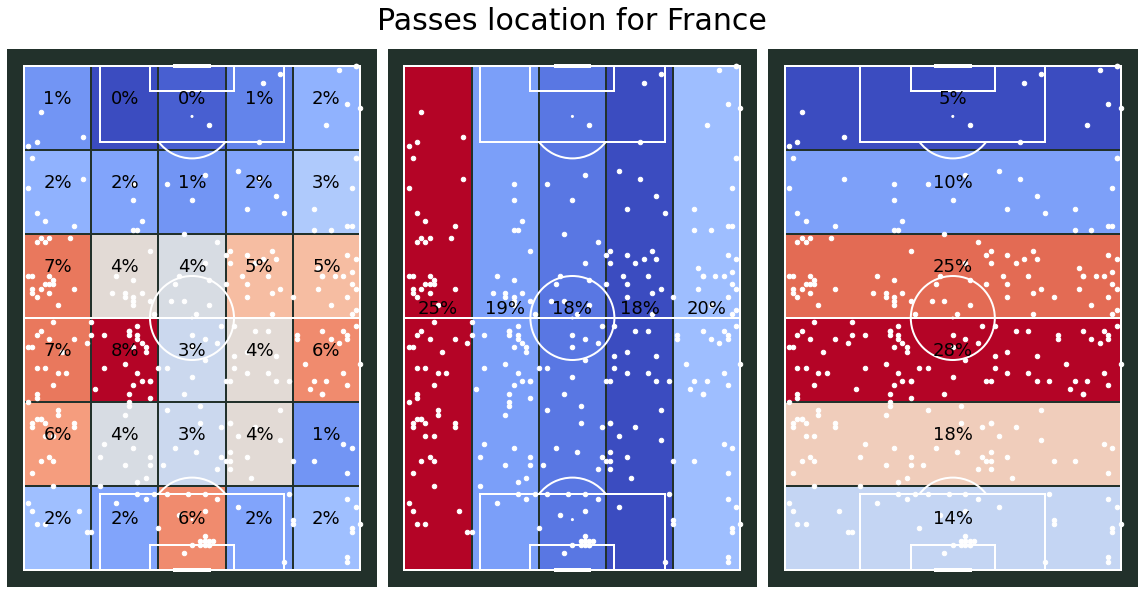

In [139]:
# Pitch setup
pitch = Pitch(pitch_type='statsbomb', figsize=(16, 9), layout=(1, 3), line_zorder=2,
              pitch_color='#22312b', line_color='white', orientation='vertical')
# Draw the pitch
fig, ax = pitch.draw()
# Heatmap specified by number of bins (x, y) for horizontal pitch
bins = [(6, 5), (1, 5), (6, 1)]
for i, bin in enumerate(bins):
    # Count number of occurances for each bin
    bin_statistic = pitch.bin_statistic(location_xy.x, location_xy.y, statistic='count', bins=bin)
    # Draw the heatmap
    pitch.heatmap(bin_statistic, ax=ax[i], cmap='coolwarm', edgecolors='#22312b')
    # Draw events points
    pitch.scatter(location_xy.x, location_xy.y, c='white', s=20, ax=ax[i])
    # Replace raw counts with percentages and add percentage sign (note immutable named tuple so used _replace)
    bin_statistic['statistic'] = (pd.DataFrame((bin_statistic['statistic'] / bin_statistic['statistic'].sum()))
                                  .applymap(lambda x: '{:.0%}'.format(x))
                                  .values)
    pitch.label_heatmap(bin_statistic, color='black', fontsize=18, ax=ax[i], ha='center', va='bottom')
title = fig.suptitle('Passes location for France', x=0.5, y=0.98, fontsize=30,)